mangas_por_genero = {
    "romance": [
        "ByebyeC-BOY", "Count3DeKimeteAgeru", "Donburakokko", "HaruichibanNoFukukoro",
        "HinagikuKenzan", "KarappoHighschool", "MadouTaiga", "MisutenaideDaisy",
        "PsychoStaff", "SamayoeruSyonenNiJunaiWo", "TensiNoHaneToAkumaNoShippo",
        "TotteokiNoABC", "YumeiroCooking", "YukiNoFuruMachi"
    ],
    "esporte": [
        "KyokugenCyclone", "TaiyouNiSmash", "UltraEleven", "ShimatteIkouze_vol01"
    ],
    "acao": [
        "DualJustice", "AkkeraKanjinchou", "Belmondo", "GarakutayaManta", "KuroidoGanka",
        "MAD_STONE", "TennenSenshiG", "ToutaMairimasu"
    ],
    "comedia": [
        "Akuhamu", "HeiseiJimen", "MagicStarGakuin", "TetsuSan", "ToutaMairimasu",
        "TapkunNoTanteisitsu", "NichijouSoup"
    ],
    "sci_fi": [
        "BEMADER_P", "LancelotFullThrottle", "PrayerHaNemurenai", "That_sIzumiko", "UchuKigekiM774"
    ],
    "misterio": [
        "BurariTessenTorimonochou", "HanzaiKousyouninMinegishiEitarou", "SyabondamaKieta"
    ],
    "drama": [
        "EienNoWith", "Hamlet"
    ],
    "fantasia": [
        "MagicianLoad", "TensiNoHaneToAkumaNoShippo", "TotteokiNoABC", "That_sIzumiko",
        "TouyouKidan", "YumeNoKayoiji", "YoumaKourin"
    ],
    "kodomo": [
        "TapkunNoTanteisitsu"
    ],
    "terror": [
        "TasogareTsushin"
    ],
    "comedia_romantica": [
        "SonokiDeABC", "WarewareHaOniDearu"
    ],
    "animal": [
        "UchiNoNyan_sDiary"
    ]
}

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [2]:
BASE_DIR = 'dataset'
SPLITS = ['test', 'train', 'validation']
IMG_SIZE = (512, 512)

In [3]:
records = []
for split in SPLITS:
    split_dir = os.path.join(BASE_DIR, split)
    for label in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for fname in os.listdir(label_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                records.append({
                    'filepath': os.path.join(label_dir, fname),
                    'split': split,
                    'label': label
                })
df = pd.DataFrame(records)
print(f"Total de imagens: {len(df)}")
df.to_csv("dataset_info.csv", index=False)


Total de imagens: 9056


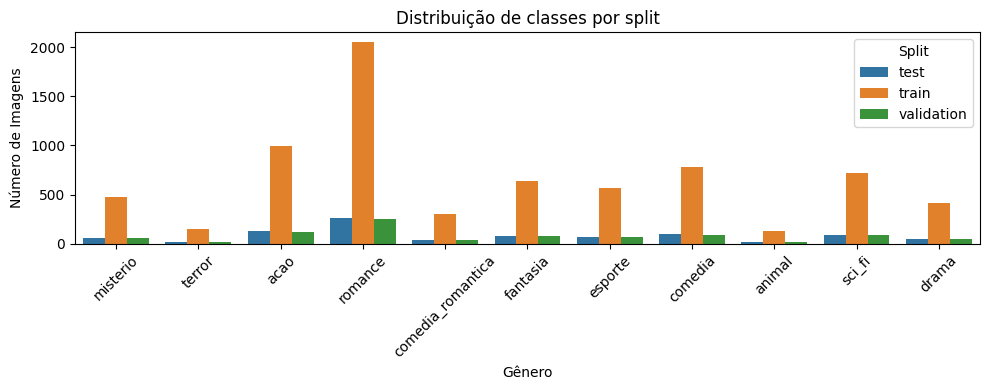

In [4]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='label', hue='split')
plt.title('Distribuição de classes por split')
plt.xlabel('Gênero')
plt.ylabel('Número de Imagens')
plt.legend(title='Split')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


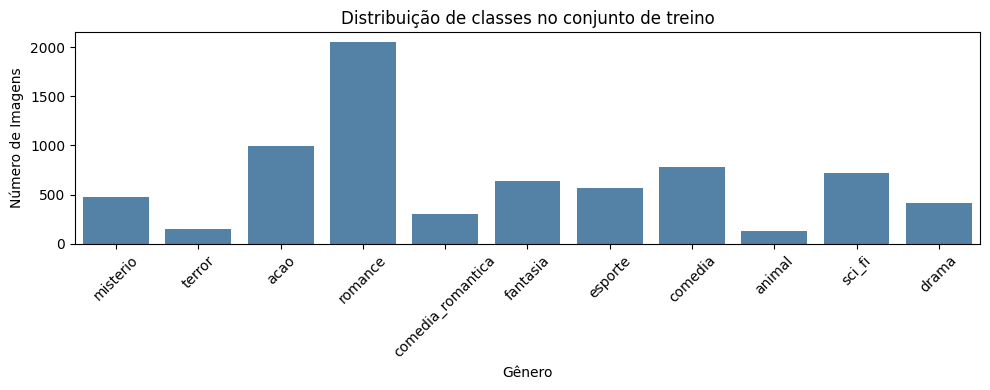

In [5]:
plt.figure(figsize=(10,4))
sns.countplot(data=df[df['split'] == 'train'], x='label', color='steelblue')
plt.title('Distribuição de classes no conjunto de treino')
plt.xlabel('Gênero')
plt.ylabel('Número de Imagens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


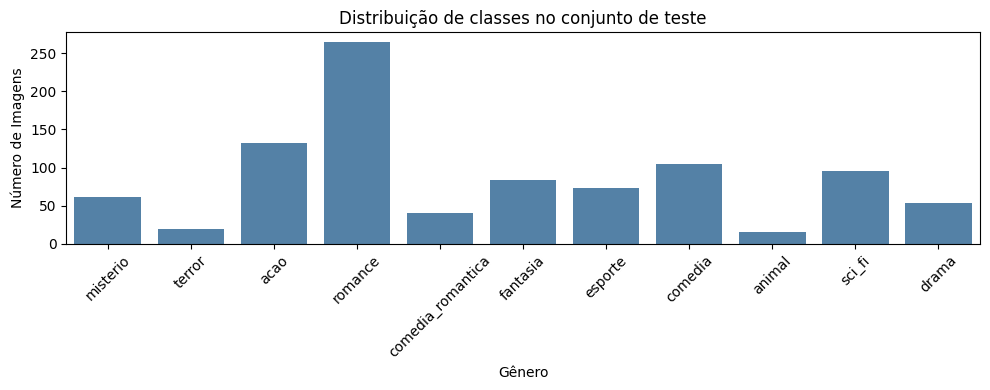

In [6]:
plt.figure(figsize=(10,4))
sns.countplot(data=df[df['split'] == 'test'], x='label', color='steelblue')
plt.title('Distribuição de classes no conjunto de teste')
plt.xlabel('Gênero')
plt.ylabel('Número de Imagens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


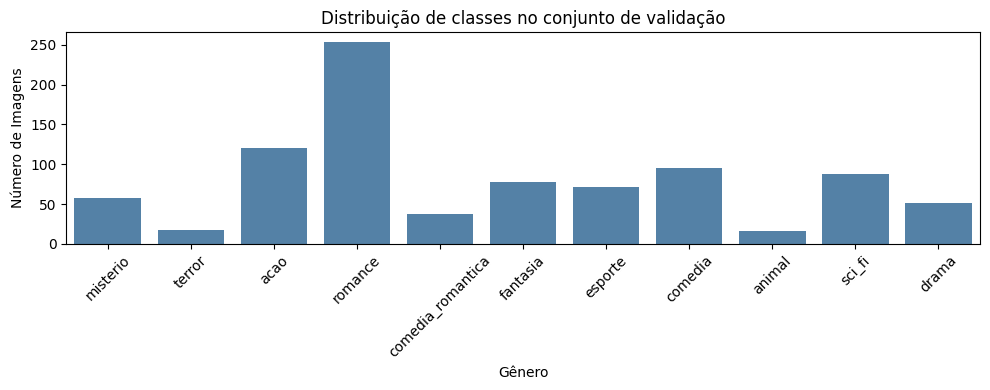

In [7]:
plt.figure(figsize=(10,4))
sns.countplot(data=df[df['split'] == 'validation'], x='label', color='steelblue')
plt.title('Distribuição de classes no conjunto de validação')
plt.xlabel('Gênero')
plt.ylabel('Número de Imagens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


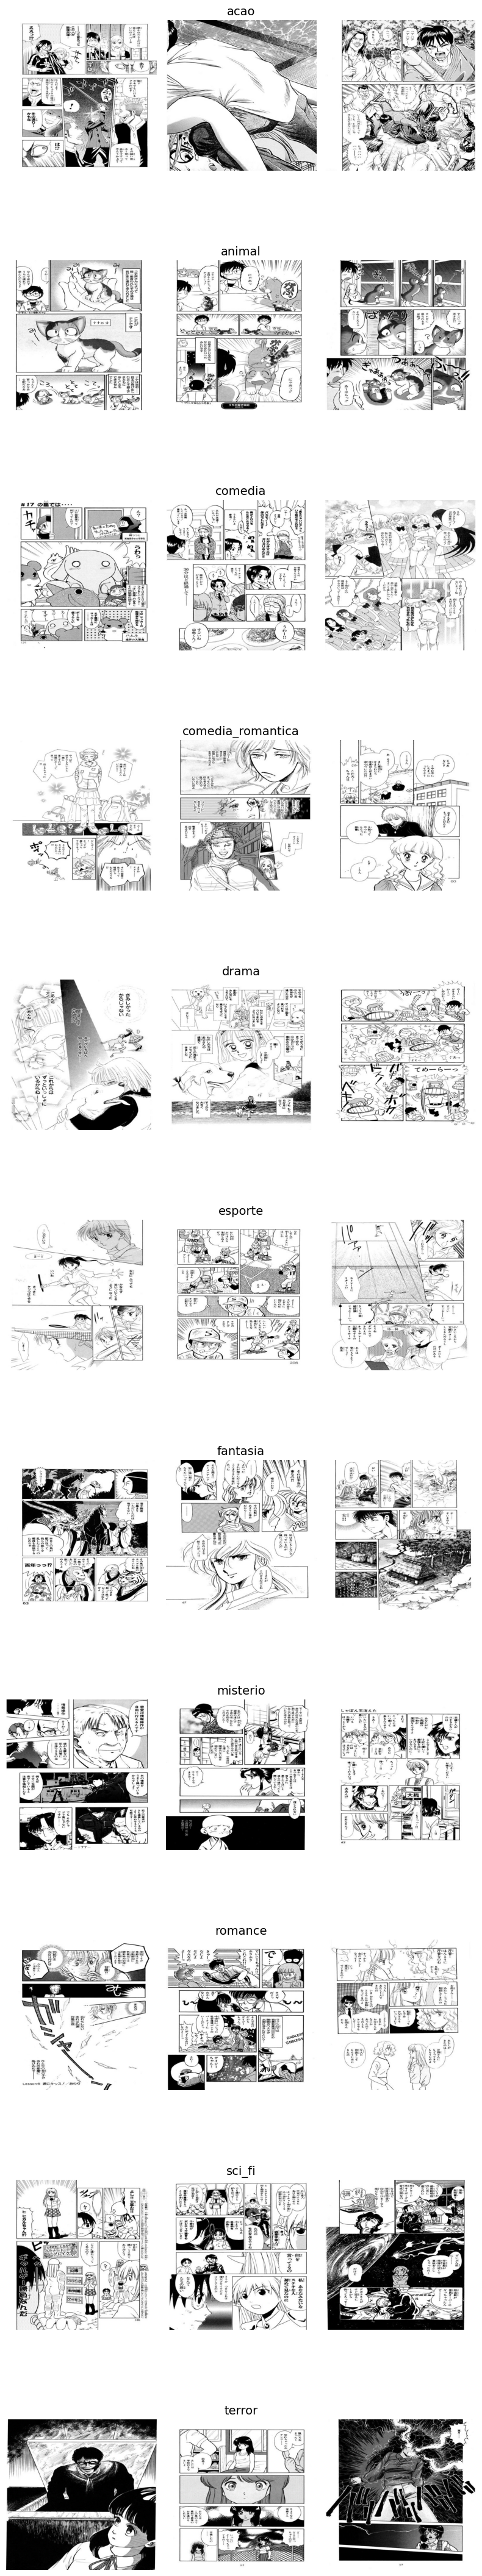

In [8]:
n_classes = df['label'].nunique()
fig, axs = plt.subplots(n_classes, 3, figsize=(8, 4*n_classes))
for i, label in enumerate(sorted(df['label'].unique())):
    sample_paths = df[df['label']==label].sample(3, random_state=42)['filepath']
    for j, path in enumerate(sample_paths):
        img = Image.open(path).convert('L')   # força grayscale
        axs[i,j].imshow(img, cmap='gray')
        axs[i,j].axis('off')
        if j==1: axs[i,j].set_title(label, fontsize=14)
plt.tight_layout()
plt.show()


Usar o que o gemini me deu: 

In [9]:
# Importações para calcular os pesos das classes e gerar métricas de avaliação
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np # Necessário para manipulação de arrays

In [10]:
import os
import pandas as pd

# --- 1. Definir o Diretório Base ---
# O caminho para a pasta principal que contém as pastas train, test e validation.
base_dir = './dataset'

# --- 2. Função para Criar um DataFrame a partir de uma Pasta (train, test ou val) ---
def create_dataframe_from_folder(folder_path):
    """
    Lê uma pasta (como 'train' ou 'test'), encontra todas as imagens
    em suas subpastas de gênero e retorna um DataFrame com os caminhos e os rótulos.
    """
    filepaths = []
    labels = []

    # Lista as pastas de gênero (Acao, Animal, etc.)
    genre_folders = os.listdir(folder_path)
    for genre in genre_folders:
        genre_path = os.path.join(folder_path, genre)
        
        # Verifica se é realmente um diretório antes de prosseguir
        if os.path.isdir(genre_path):
            # Lista todos os arquivos de imagem na pasta do gênero
            image_files = os.listdir(genre_path)
            for file in image_files:
                # Cria o caminho completo para o arquivo
                filepath = os.path.join(genre_path, file)
                filepaths.append(filepath)
                labels.append(genre)

    # Cria o DataFrame
    df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
    return df

# --- 3. Criar os DataFrames para cada Conjunto ---
# Define os caminhos para cada pasta
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'validation')
test_path = os.path.join(base_dir, 'test')

# Cria um DataFrame para cada conjunto usando a função
df_train = create_dataframe_from_folder(train_path)
df_val = create_dataframe_from_folder(val_path)
df_test = create_dataframe_from_folder(test_path)

# Embaralha os DataFrames para garantir que os dados não estejam ordenados (opcional, mas bom para visualização)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_val = df_val.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)


# --- 4. Verificação ---
# Imprime a quantidade de amostras em cada conjunto para confirmar.
print(f"DataFrame de Treino criado com {len(df_train)} amostras.")
print(f"DataFrame de Validação criado com {len(df_val)} amostras.")
print(f"DataFrame de Teste criado com {len(df_test)} amostras.")
print("\nExemplo do df_train:")
print(df_train.head())

DataFrame de Treino criado com 7226 amostras.
DataFrame de Validação criado com 886 amostras.
DataFrame de Teste criado com 944 amostras.

Exemplo do df_train:
                                           filepaths   labels
0  ./dataset/train/romance/Count3DeKimeteAgeru_05...  romance
1         ./dataset/train/drama/EienNoWith_010_2.jpg    drama
2     ./dataset/train/comedia/NichijouSoup_088_2.jpg  comedia
3  ./dataset/train/comedia/TapkunNoTanteisitsu_02...  comedia
4     ./dataset/train/acao/GarakutayaManta_081_1.jpg     acao


In [11]:
# --- Implementando Data Augmentation ---

# Crie um novo gerador de imagens para o TREINO com várias transformações
train_datagen_augmented = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,             # Normaliza os pixels para o intervalo [0, 1]
    rotation_range=20,          # Rotaciona a imagem em até 20 graus
    width_shift_range=0.2,      # Desloca a imagem horizontalmente
    height_shift_range=0.2,     # Desloca a imagem verticalmente
    shear_range=0.2,            # Aplica cortes na imagem
    zoom_range=0.2,             # Aplica zoom na imagem
    horizontal_flip=True,       # Inverte a imagem horizontalmente
    fill_mode='nearest'         # Preenche pixels novos com o valor do vizinho mais próximo
)

# O gerador para validação e teste não deve ter augmentation, apenas o rescale
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Recrie os geradores (assumindo que você já tem o DataFrame 'df_train', 'df_val' e 'df_test')
# ATENÇÃO: Verifique se os nomes das colunas ('filepaths' e 'labels') e dos DataFrames estão corretos
IMG_SIZE = (512, 512) # Garanta que o IMG_SIZE seja o mesmo usado anteriormente
BATCH_SIZE = 32       # Defina o tamanho do batch

train_generator_aug = train_datagen_augmented.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    color_mode='rgb', # Mude para 'rgb' para usar modelos pré-treinados
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator_aug = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator_aug = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Geradores com Data Augmentation criados!")

Found 7226 validated image filenames belonging to 11 classes.
Found 886 validated image filenames belonging to 11 classes.
Found 944 validated image filenames belonging to 11 classes.
Geradores com Data Augmentation criados!


In [12]:
# --- Lidando com o Desbalanceamento de Classes ---

# Obtenha as classes do gerador de treino
# O gerador precisa ser 'não-embaralhado' (shuffle=False) para garantir a ordem correta,
# mas para o cálculo dos pesos, podemos usar as classes diretamente do gerador com shuffle.
class_labels = train_generator_aug.classes

# Calcule os pesos das classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Crie um dicionário mapeando o índice da classe para o seu peso
class_weights_dict = dict(enumerate(class_weights))

print("Pesos das classes calculados:")
print(class_weights_dict)

Pesos das classes calculados:
{0: np.float64(0.6588857481535516), 1: np.float64(5.1321022727272725), 2: np.float64(0.8432722604738009), 3: np.float64(2.168016801680168), 4: np.float64(1.5829134720700986), 5: np.float64(1.1524720893141946), 6: np.float64(1.023222883035967), 7: np.float64(1.3858841580360568), 8: np.float64(0.3209130878891504), 9: np.float64(0.9085879542311077), 10: np.float64(4.438574938574939)}


In [14]:
# --- Construindo o Modelo com Transfer Learning (MobileNetV2) ---

# Carrega o modelo MobileNetV2 pré-treinado na base de dados ImageNet
# include_top=False: remove a camada de classificação original do modelo
# input_shape: especifica o tamanho e o número de canais da nossa imagem (3 para RGB)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# Congela as camadas do modelo base para que não sejam treinadas novamente
base_model.trainable = False

# Adiciona nossas próprias camadas de classificação no topo do modelo base
model_tl = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), # Reduz a dimensionalidade
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(train_generator_aug.class_indices), activation='softmax') # Camada de saída
])

# Compila o novo modelo
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Exibe a arquitetura do novo modelo
model_tl.summary()

/var/folders/h4/_q955b152455d1dtsykcx3tw0000gn/T/ipykernel_4104/410334741.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 16, 16, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,371 (9.24 MB)

 Trainable params: 165,387 (646.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3025 - loss: 1.6055

226/226 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.3090 - loss: 1.5964 - val_accuracy: 0.3646 - val_loss: 1.7755
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3342 - loss: 1.5886

226/226 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.3270 - loss: 1.5585 - val_accuracy: 0.4120 - val_loss: 1.6977
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.3386 - loss: 1.5505 - val_accuracy: 0.3837 - val_loss: 1.7147
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.3321 - loss: 1.5147 - val_accuracy: 0.3837 - val_loss: 1.7530
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.3385 - loss: 1.5133 - val_accuracy: 0.3612 - val_loss: 1.7483
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3389 - loss: 1.4779

226/226 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.3433 - loss: 1.4772 - val_accuracy: 0.3713 - val_loss: 1.6918
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3420 - loss: 1.4825

226/226 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.3447 - loss: 1.4654 - val_accuracy: 0.4582 - val_loss: 1.5808
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.3501 - loss: 1.4646 - val_accuracy: 0.3533 - val_loss: 1.7546
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.3550 - loss: 1.4632 - val_accuracy: 0.4074 - val_loss: 1.6581
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step - accuracy: 0.3703 - loss: 1.4171 - val_accuracy: 0.4029 - val_loss: 1.6698
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 798s 4s/step - accuracy: 0.3709 - loss: 1.4261 - val_accuracy: 0.4312 - val_loss: 1.6544
Epoch 12/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 833s 4s/step - accuracy: 0.3678 - loss: 1.4192 - val_accuracy: 0.3747 - val_loss: 1.7711

--- Avaliação no Conjunto de Teste ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step

Relatório de Classificação:
                   precision    recall  f1-score   support

             acao       0.45      0.23      0.30       132
       

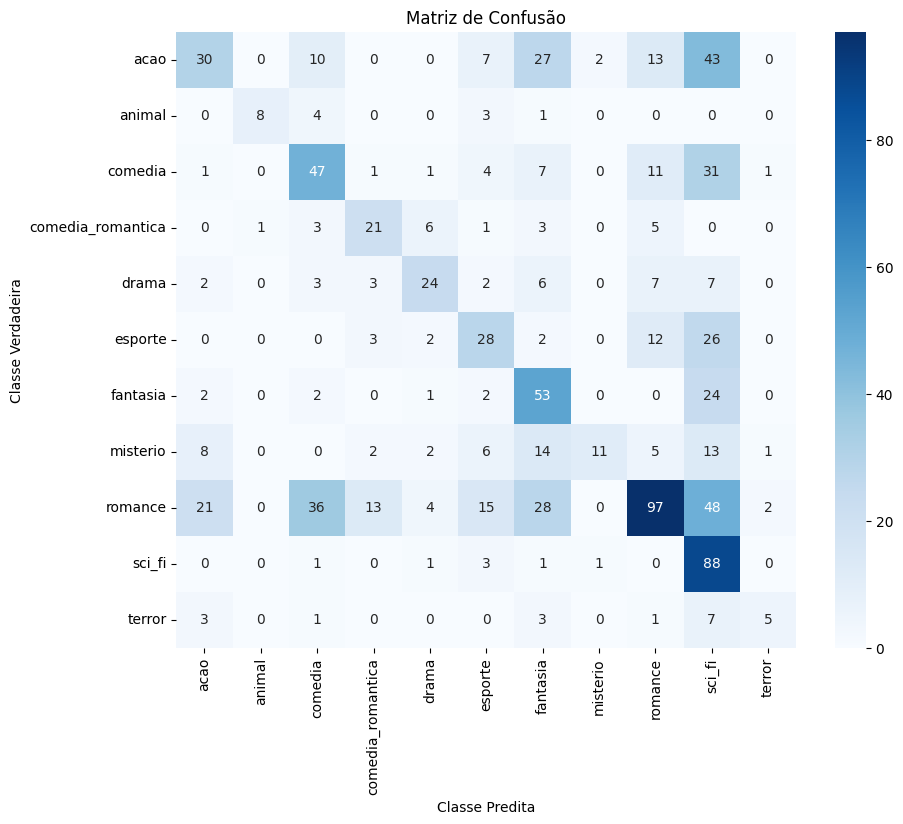


Melhor modelo salvo com sucesso como 'modelo_manga_melhor_versao.h5'


In [17]:
# --- Treinamento e Avaliação ---
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Treinamento e Avaliação (Versão Melhorada) ---

# Aumentamos o número de épocas para um valor alto (ex: 50).
# O EarlyStopping vai parar o treino quando o modelo parar de melhorar.
EPOCHS = 50

# Callback para parar o treino se a perda na validação (val_loss) não melhorar
# por 5 épocas seguidas (patience=5).
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True # Restaura os pesos da melhor época ao final
)

# Callback para salvar o melhor modelo encontrado durante o treino
# Apenas o modelo com a menor 'val_loss' será salvo.
model_checkpoint = ModelCheckpoint(
    filepath='modelo_manga_melhor_versao.h5', # Novo nome para o melhor modelo
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)


# Treina o modelo usando os callbacks
history_tl = model_tl.fit(
    train_generator_aug,
    validation_data=val_generator_aug,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint] # Adiciona os callbacks aqui
)

print("\n--- Avaliação no Conjunto de Teste ---")
# Faz predições no conjunto de teste
# O modelo já estará com os melhores pesos por causa do 'restore_best_weights=True'
predictions = model_tl.predict(test_generator_aug)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator_aug.classes
class_names = list(test_generator_aug.class_indices.keys())

# 1. Relatório de Classificação (com precisão, recall, f1-score)
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 2. Matriz de Confusão
print("\nMatriz de Confusão:")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

print("\nMelhor modelo salvo com sucesso como 'modelo_manga_melhor_versao.h5'")

\nIniciando a fase de Fine-Tuning...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 16, 16, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,371 (9.24 MB)

 Trainable params: 2,026,827 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

\nContinuando o treinamento com Fine-Tuning...
Epoch 12/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.2416 - loss: 2.0712 - val_accuracy: 0.3442 - val_loss: 1.9986
Epoch 13/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - accuracy: 0.2935 - loss: 1.6558 - val_accuracy: 0.3307 - val_loss: 2.0096
Epoch 14/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.3200 - loss: 1.5588 - val_accuracy: 0.3691 - val_loss: 1.8526
Epoch 15/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.3424 - loss: 1.4947 - val_accuracy: 0.3770 - val_loss: 1.8076
Epoch 16/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - accuracy: 0.3402 - loss: 1.4457 - val_accuracy: 0.4300 - val_loss: 1.5927
\n--- Avaliação FINAL no Conjunto de Teste (Após Fine-Tuning) ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
\nRelatório de Classificação Final:
                   precision    recall  f1-score   support

             acao       0.31      0.08      0.12       132
           animal       1.00      0.56     

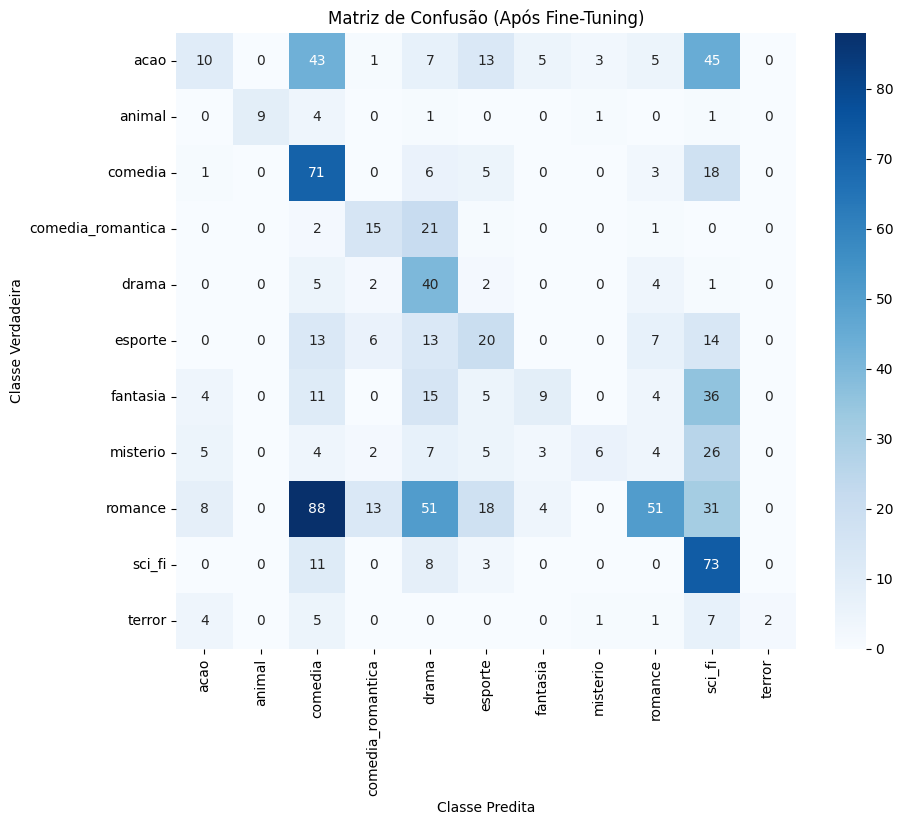

In [18]:
class_names# --- Etapa de Fine-Tuning (Ajuste Fino) ---

print("\\nIniciando a fase de Fine-Tuning...")

# 1. Descongelar o modelo base para que possamos treinar suas camadas
base_model.trainable = True

# Opcional, mas recomendado: Vamos manter as primeiras camadas congeladas.
# As primeiras camadas aprendem características muito gerais (linhas, cores).
# É mais eficaz ajustar as camadas posteriores, que aprendem características mais complexas.
# Vamos congelar as primeiras 100 camadas e treinar o restante.
for layer in base_model.layers[:100]:
    layer.trainable = False

# 2. Re-compilar o modelo com uma taxa de aprendizado MUITO BAIXA
# Isso é CRUCIAL para não destruir os pesos pré-treinados.
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-5) # 0.00001
model_tl.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer_fine_tune,
    metrics=['accuracy']
)

# Mostra o resumo para ver as camadas treináveis agora
model_tl.summary()


# 3. Continuar o treinamento (Fine-Tuning)
# Usaremos os mesmos callbacks de antes para parar quando não houver melhora.
print("\\nContinuando o treinamento com Fine-Tuning...")

# Aumentamos o número de épocas novamente
# O EarlyStopping vai cuidar de parar no momento certo
fine_tune_epochs = 20
total_epochs = 10 + fine_tune_epochs # O número de épocas do treino anterior + as novas

history_fine_tune = model_tl.fit(
    train_generator_aug,
    epochs=total_epochs,
    initial_epoch=history_tl.epoch[-1], # Começa a contar as épocas de onde parou
    validation_data=val_generator_aug,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint] # Reutilizamos os mesmos callbacks
)

# --- Avaliação FINAL após o Fine-Tuning ---
print("\\n--- Avaliação FINAL no Conjunto de Teste (Após Fine-Tuning) ---")
predictions_ft = model_tl.predict(test_generator_aug)
y_pred_ft = np.argmax(predictions_ft, axis=1)
y_true_ft = test_generator_aug.classes

print("\\nRelatório de Classificação Final:")
print(classification_report(y_true_ft, y_pred_ft, target_names=class_names))

print("\\nMatriz de Confusão Final:")
conf_matrix_ft = confusion_matrix(y_true_ft, y_pred_ft)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão (Após Fine-Tuning)')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

In [21]:
# --- Treinamento INICIAL (Mais Paciente) ---
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Aumentamos a paciência para garantir a estabilização completa
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Aumentado de 5 para 10
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='modelo_inicial_melhor_versao.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Treina o modelo com a cabeça congelada
history_tl = model_tl.fit(
    train_generator_aug,
    validation_data=val_generator_aug,
    epochs=50, # O EarlyStopping vai parar antes se necessário
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint]
)

# Avalie este primeiro resultado para ter uma base de comparação
print("\\n--- Avaliação APÓS TREINO INICIAL ---")
model_tl.evaluate(test_generator_aug)

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5600 - loss: 0.8682

226/226 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - accuracy: 0.5588 - loss: 0.8523 - val_accuracy: 0.5914 - val_loss: 1.1720
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5759 - loss: 0.8165

226/226 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.5715 - loss: 0.8325 - val_accuracy: 0.6005 - val_loss: 1.1576
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 603s 3s/step - accuracy: 0.5707 - loss: 0.8407 - val_accuracy: 0.5982 - val_loss: 1.1578
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5777 - loss: 0.8072

226/226 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - accuracy: 0.5804 - loss: 0.8130 - val_accuracy: 0.6163 - val_loss: 1.1251
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.5887 - loss: 0.8074 - val_accuracy: 0.6016 - val_loss: 1.1726
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - accuracy: 0.5886 - loss: 0.8058 - val_accuracy: 0.5903 - val_loss: 1.2198
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.6111 - loss: 0.7624 - val_accuracy: 0.6005 - val_loss: 1.1794
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.6091 - loss: 0.7737 - val_accuracy: 0.5914 - val_loss: 1.2437
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6093 - loss: 0.7480

226/226 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.6089 - loss: 0.7493 - val_accuracy: 0.6219 - val_loss: 1.1198
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.6248 - loss: 0.7352 - val_accuracy: 0.5688 - val_loss: 1.3006
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6120 - loss: 0.7372

226/226 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.6108 - loss: 0.7431 - val_accuracy: 0.6230 - val_loss: 1.1172
Epoch 12/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step - accuracy: 0.6261 - loss: 0.7319 - val_accuracy: 0.6084 - val_loss: 1.1773
Epoch 13/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.6302 - loss: 0.6981 - val_accuracy: 0.6151 - val_loss: 1.1190
Epoch 14/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6411 - loss: 0.6796

226/226 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.6502 - loss: 0.6825 - val_accuracy: 0.6512 - val_loss: 1.0264
Epoch 15/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6370 - loss: 0.7025

226/226 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.6442 - loss: 0.6873 - val_accuracy: 0.6659 - val_loss: 0.9874
Epoch 16/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6613 - loss: 0.6557

226/226 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.6518 - loss: 0.6799 - val_accuracy: 0.6716 - val_loss: 0.9651
Epoch 17/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6559 - loss: 0.6731

226/226 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.6636 - loss: 0.6486 - val_accuracy: 0.6862 - val_loss: 0.9369
Epoch 18/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.6580 - loss: 0.6552 - val_accuracy: 0.6783 - val_loss: 0.9407
Epoch 19/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.6764 - loss: 0.6182 - val_accuracy: 0.6456 - val_loss: 1.0425
Epoch 20/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.6728 - loss: 0.6350 - val_accuracy: 0.6817 - val_loss: 0.9437
Epoch 21/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.6849 - loss: 0.6225 - val_accuracy: 0.6806 - val_loss: 0.9572
Epoch 22/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.6895 - loss: 0.5954 - val_accuracy: 0.6851 - val_loss: 0.9540
Epoch 23/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6988 - loss: 0.5891

226/226 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.6897 - loss: 0.5999 - val_accuracy: 0.6862 - val_loss: 0.9328
Epoch 24/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7049 - loss: 0.5777

226/226 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.7027 - loss: 0.5830 - val_accuracy: 0.7111 - val_loss: 0.8629
Epoch 25/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7165 - loss: 0.5664

226/226 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.7146 - loss: 0.5737 - val_accuracy: 0.7223 - val_loss: 0.8113
Epoch 26/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.7139 - loss: 0.5711 - val_accuracy: 0.6941 - val_loss: 0.8806
Epoch 27/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.7209 - loss: 0.5500 - val_accuracy: 0.7043 - val_loss: 0.8956
Epoch 28/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.7123 - loss: 0.5669 - val_accuracy: 0.7178 - val_loss: 0.8747
Epoch 29/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.7225 - loss: 0.5493 - val_accuracy: 0.7032 - val_loss: 0.9072
Epoch 30/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.7271 - loss: 0.5385 - val_accuracy: 0.7190 - val_loss: 0.8540
Epoch 31/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.7473 - loss: 0.5161 - val_accuracy: 0.6941 - val_loss: 0.9510
Epoch 32/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.7440 - loss: 0.5200 - val_accuracy

[0.7718338370323181, 0.75]

In [22]:
# --- Etapa de Fine-Tuning (MUITO Cauteloso) ---

print("\\nIniciando a fase de Fine-Tuning Cauteloso...")

# 1. Descongelar apenas as ÚLTIMAS 20 camadas do modelo base
base_model.trainable = True
for layer in base_model.layers[:-20]: # Congela tudo, exceto as últimas 20
    layer.trainable = False

# 2. Re-compilar com uma taxa de aprendizado EXTREMAMENTE BAIXA
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-6) # Reduzido de 1e-5 para 1e-6
model_tl.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer_fine_tune,
    metrics=['accuracy']
)

# 3. Continuar o treinamento
# Redefinimos o EarlyStopping para o fine-tuning
early_stopping_ft = EarlyStopping(
    monitor='val_loss',
    patience=5, # Podemos usar uma paciência menor aqui
    restore_best_weights=True
)

history_fine_tune = model_tl.fit(
    train_generator_aug,
    epochs=history_tl.epoch[-1] + 20, # Treina por mais 20 épocas no máximo
    initial_epoch=history_tl.epoch[-1],
    validation_data=val_generator_aug,
    class_weight=class_weights_dict,
    callbacks=[early_stopping_ft] # Usando o novo callback
)

# --- Avaliação FINAL após o Fine-Tuning Cauteloso ---
print("\\n--- Avaliação FINAL no Conjunto de Teste (Após Fine-Tuning Cauteloso) ---")
predictions_ft = model_tl.predict(test_generator_aug)
y_pred_ft = np.argmax(predictions_ft, axis=1)
y_true_ft = test_generator_aug.classes
class_names = list(test_generator_aug.class_indices.keys())

print("\\nRelatório de Classificação Final:")
print(classification_report(y_true_ft, y_pred_ft, target_names=class_names))

\nIniciando a fase de Fine-Tuning Cauteloso...
Epoch 35/54
226/226 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.7105 - loss: 0.5545 - val_accuracy: 0.7178 - val_loss: 0.8157
Epoch 36/54
226/226 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.7155 - loss: 0.5560 - val_accuracy: 0.7201 - val_loss: 0.8164
Epoch 37/54
226/226 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.7164 - loss: 0.5636 - val_accuracy: 0.7167 - val_loss: 0.8269
Epoch 38/54
226/226 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.7110 - loss: 0.5678 - val_accuracy: 0.7144 - val_loss: 0.8334
Epoch 39/54
226/226 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.7138 - loss: 0.5567 - val_accuracy: 0.7167 - val_loss: 0.8275
Epoch 40/54
226/226 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.7181 - loss: 0.5531 - val_accuracy: 0.7178 - val_loss: 0.8300
\n--- Avaliação FINAL no Conjunto de Teste (Após Fine-Tuning Cauteloso) ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step
\nRelatório de Classificação Final:
                   pre

--- Avaliação Final de Generalização no Conjunto de Teste ---
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 833ms/step

Relatório de Classificação Final:
                   precision    recall  f1-score   support

             acao       0.70      0.70      0.70       132
           animal       1.00      0.81      0.90        16
          comedia       0.77      0.84      0.80       104
comedia_romantica       0.91      0.75      0.82        40
            drama       0.81      0.81      0.81        54
          esporte       0.76      0.82      0.79        73
         fantasia       0.84      0.83      0.84        84
         misterio       0.79      0.50      0.61        62
          romance       0.89      0.66      0.75       264
           sci_fi       0.50      0.99      0.66        95
           terror       0.93      0.70      0.80        20

         accuracy                           0.75       944
        macro avg       0.81      0.76      0.77       944
     weighted avg       0.79     

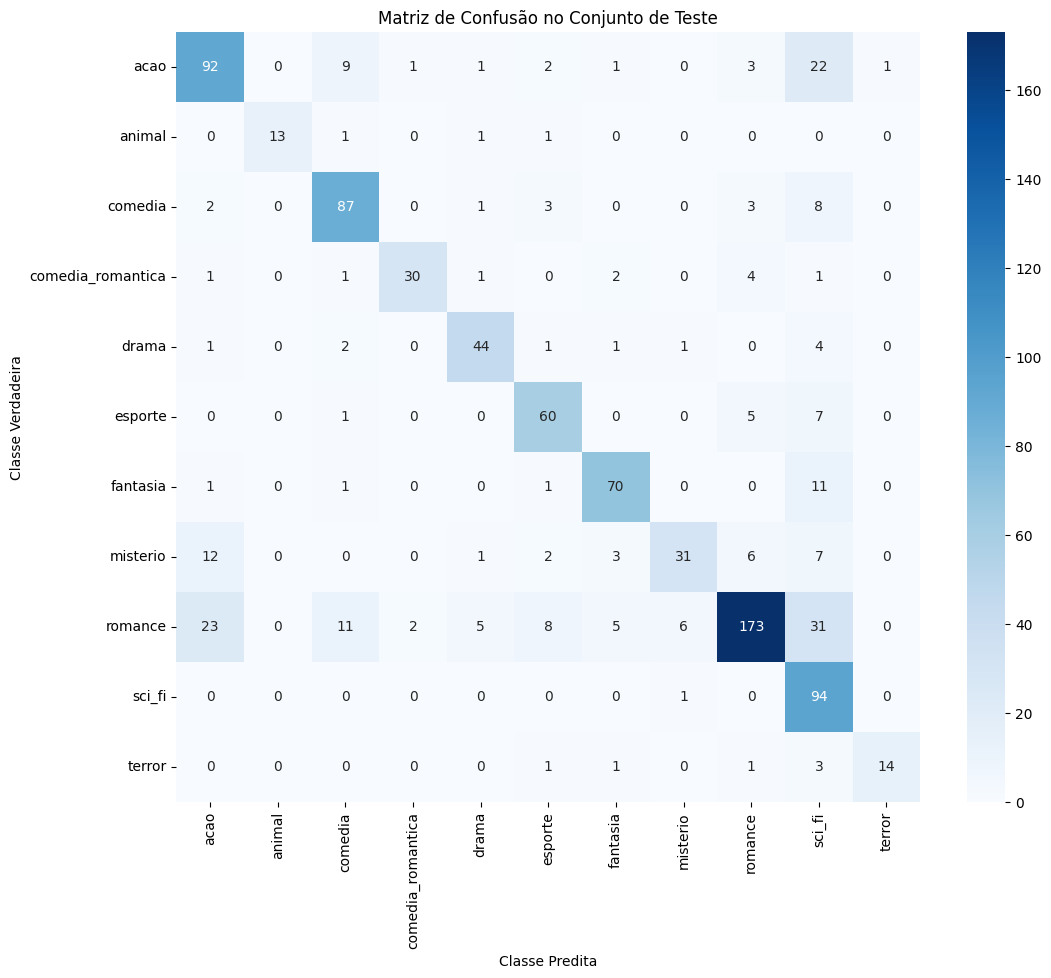

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("--- Avaliação Final de Generalização no Conjunto de Teste ---")

# Garanta que o gerador de teste não embaralhe os dados para a avaliação
test_generator_aug.reset() 

# Fazer predições no conjunto de teste
predictions = model_tl.predict(test_generator_aug)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator_aug.classes
class_names = list(test_generator_aug.class_indices.keys())

# 1. Relatório de Classificação Final
# Este relatório é a principal medida de desempenho em dados não vistos.
print("\nRelatório de Classificação Final:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 2. Matriz de Confusão Final
# A matriz de confusão nos mostra visualmente se o modelo está confundindo classes específicas.
# Uma diagonal forte, como a sua, indica boa generalização e baixo overfitting.
print("\nMatriz de Confusão Final:")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão no Conjunto de Teste')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()